# Cleaning Notebooks


In [1]:
# Imports and Environmental Setup
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '..')

import matplotlib
%matplotlib inline

import ipywidgets 
import agglomerative

import os
import glob

import pandas as pd
import numpy as np
import networkx as nx

from lineage import graphs, similarity

import clustering
import logging
import seaborn as sns
import matplotlib.pyplot as plt

logger = logging.getLogger()
logger.setLevel(logging.INFO)

pd.options.mode.chained_assignment = None


In [6]:
# Deduping study

from collections import defaultdict
import glob


def get_notebook_artifact_list(nb):
    artifact_dir = RESULT_DIR+nb+'/artifacts/'
    return [os.path.basename(x) for x in glob.glob(artifact_dir+'*.csv')]


def generate_artifact_dict(notebooks):
    notebook_dict = defaultdict(list)
    for nb in notebooks:
        artifacts = frozenset(get_notebook_artifact_list(nb))
        notebook_dict[artifacts].append(nb)
        
    return notebook_dict
        
        
def find_duplicates(artifact_dict):
    return dict(filter(lambda x: len(x[1]) > 1 , artifact_dict.items()))
    

def dedup_notebooks(notebooks):
    artifact_dict = generate_artifact_dict(notebooks)
    final_list = []
    for afs,nbs in artifact_dict.items():
        final_list.append(nbs[0])
        
    return final_list

In [8]:
def compute_nb_cardinality(RESULT_DIR, selected_nb, base_table_only=False):
    nb_data = []
    
    def compute_df_cardinality(nb_name,df_dict, df):
        df_data = []
        df_data.extend([{
                'colname': col,
                'cardinality': len(df_dict[df][col].unique()),
                'index_len': len(df_dict[df].index),
                'nb_name': nb_name,
                'df_name': df
            } for col in df_dict[df].columns])
        return df_data
    
    df_dict = similarity.load_dataset_dir(RESULT_DIR+selected_nb+'/artifacts/', '*.csv', index_col=0)
    df_list = []
    if base_table_only:
        try:
            g = graphs.get_graph(RESULT_DIR, selected_nb)
            indeg = g.in_degree()
            to_keep = [n for (n, deg) in indeg if deg == 0]
            g_copy = g.subgraph(to_keep)
            df_list = g_copy.nodes()
            logging.debug('Selected '+ str(len(df_list)) + ' base tables from '+ str(len(df_dict.keys())))
        except FileNotFoundError as e:
            logging.warning('Ground Truth not present for nb_name: '+selected_nb)
    else:
        df_list = df_dict.keys()
    for df in df_list: 
        try:
            nb_data.extend(compute_df_cardinality(selected_nb,df_dict,df))
        except (KeyError, FileNotFoundError) as e:
            logging.warning('File: '+df+' missing in workflow: '+ selected_nb)
    
    return pd.DataFrame(nb_data)

def compute_bulk_cardinality(RESULT_DIR, dedup=False, base_table_only=True):
    notebooks = [d for d in os.listdir(RESULT_DIR) if os.path.isdir(os.path.join(RESULT_DIR, d))]
    if dedup:
        notebooks = dedup_notebooks(notebooks)
    result_df = pd.concat([compute_nb_cardinality(RESULT_DIR,nb, base_table_only=base_table_only) for nb in notebooks], ignore_index=True)
    result_df = result_df.loc[result_df.index_len > 0]
    result_df['card_ratio'] = result_df.apply(lambda r: r['cardinality'] /  r['index_len'], axis=1)
    return result_df

def plot_cardinality(result_df, nb_type, ylim=None):
    grouped_sorted = result_df.groupby(['colname','nb_name']).mean().sort_values('card_ratio')#.hist('card_ratio')
    num_nbs  = str(len(result_df.nb_name.unique()))
    num_dfs = str(len(result_df.groupby(['nb_name', 'df_name']).max().index))
    num_cols = str(len(grouped_sorted.index))
    ax=grouped_sorted.hist('card_ratio')
    ax[0][0].set_title('Column Uniqueness for '+num_nbs+' '+nb_type +' workflows with ' + 
                       num_dfs+' dataframes and '+ num_cols + ' columns')
    ax[0][0].set_xlabel('Column Cardinality / Number of Rows')
    ax[0][0].set_ylabel('Number of Workflows')
    if ylim:
        ax[0][0].set_ylim(ylim)
    
    return ax

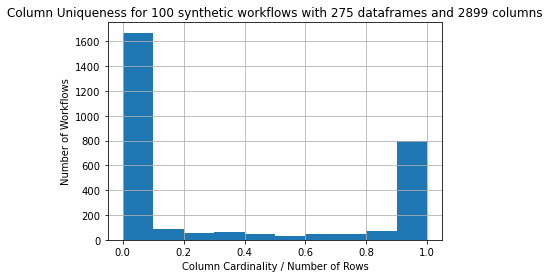

In [25]:
dir1 = '/home/suhail/Projects/sample_workflows/million_notebooks/selected/'
dir2 = '/home/suhail/Projects/relic/primitives/python/generator/dataset_flat_full/'
dir3 = '/home/suhail/ok/'

#df1 = compute_bulk_cardinality(dir3, base_table_only=False)
#_ = plot_cardinality(df1, 'real', ylim=(0,12000))
#df2 = compute_bulk_cardinality(dir3, base_table_only=True)
#_ = plot_cardinality(df2, 'real', ylim=(0,12000))
#df3 = compute_bulk_cardinality(dir2, dedup=False, base_table_only=False)
#_ = plot_cardinality(df3, 'synthetic', ylim=(0,3000))
df4 = compute_bulk_cardinality(dir2, dedup=False, base_table_only=True)
_ = plot_cardinality(df4, 'synthetic')

In [12]:
import qgrid
grouped_sorted = df1.groupby(['colname','nb_name']).mean().sort_values('card_ratio')
qgrid_widget = qgrid.show_grid(df1, show_toolbar=True)
qgrid_widget


QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [42]:
# Find the number of DFs for each notebook:
dfs_per_nb = df1.groupby('nb_name')[['df_name']].nunique()
dfs_per_nb

index_per_nb = df1[['nb_name','index_len']].drop_duplicates()

nb_index_df_list = index_per_nb.merge(dfs_per_nb, on='nb_name')
nb_index_df_list = nb_index_df_list.sort_values('index_len', ascending=False)

nb_prefix = "<a href=\"https://flamingo.cs.uchicago.edu/jupyter/notebooks/nbs/"
nb_suffix = "\" target=\"_blank\">Notebook</a>"
nb_index_df_list['url'] = nb_index_df_list['nb_name'].apply(lambda x: nb_prefix+x+nb_suffix)
dedup = nb_index_df_list.groupby('nb_name').max().sort_values('index_len', ascending=False)
#nb_index_df_list.plot.scatter('index_len', 'df_name')
#nb_index_df_list

In [40]:
nb_index_df_list['url'][0]

'<a href="https://flamingo.cs.uchicago.edu/jupyter/notebooks/nbs/nb_1195712.ipynb" target="_blank">Notebook</a>'

In [43]:
qgrid_widget = qgrid.show_grid(dedup, show_toolbar=True)
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [ ]:
selected_nbs = 
[
    ''
]

# Column Statistics for Real Dataframes

In [23]:
import qgrid
qgrid_widget = qgrid.show_grid(nb_index_df_list, show_toolbar=True)
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [73]:
 df

,colname,cardinality,index_len,nb_name,df_name,card_ratio
0,PassengerId,295,295,nb_1195712.ipynb,X_test.csv,1.000000
1,Pclass,3,295,nb_1195712.ipynb,X_test.csv,0.010169
2,Sex,3,295,nb_1195712.ipynb,X_test.csv,0.010169
3,Age,69,295,nb_1195712.ipynb,X_test.csv,0.233898
4,SibSp,5,295,nb_1195712.ipynb,X_test.csv,0.016949
...,...,...,...,...,...,...
16121,symmetry-se,181,188,nb_294875.ipynb,X_test.csv,0.962766
16122,symmetry-worst,186,188,nb_294875.ipynb,X_test.csv,0.989362
16123,fractal_dimension-mean,180,188,nb_294875.ipynb,X_test.csv,0.957447
16124,fractal_dimension-se,180,188,nb_294875.ipynb,X_test.csv,0.957447


In [95]:
# Analyse the descripency between the number of workflows when filtered by base tables only.
left_out = list(set(df1.nb_name.unique()) - set(df2.nb_name.unique()))

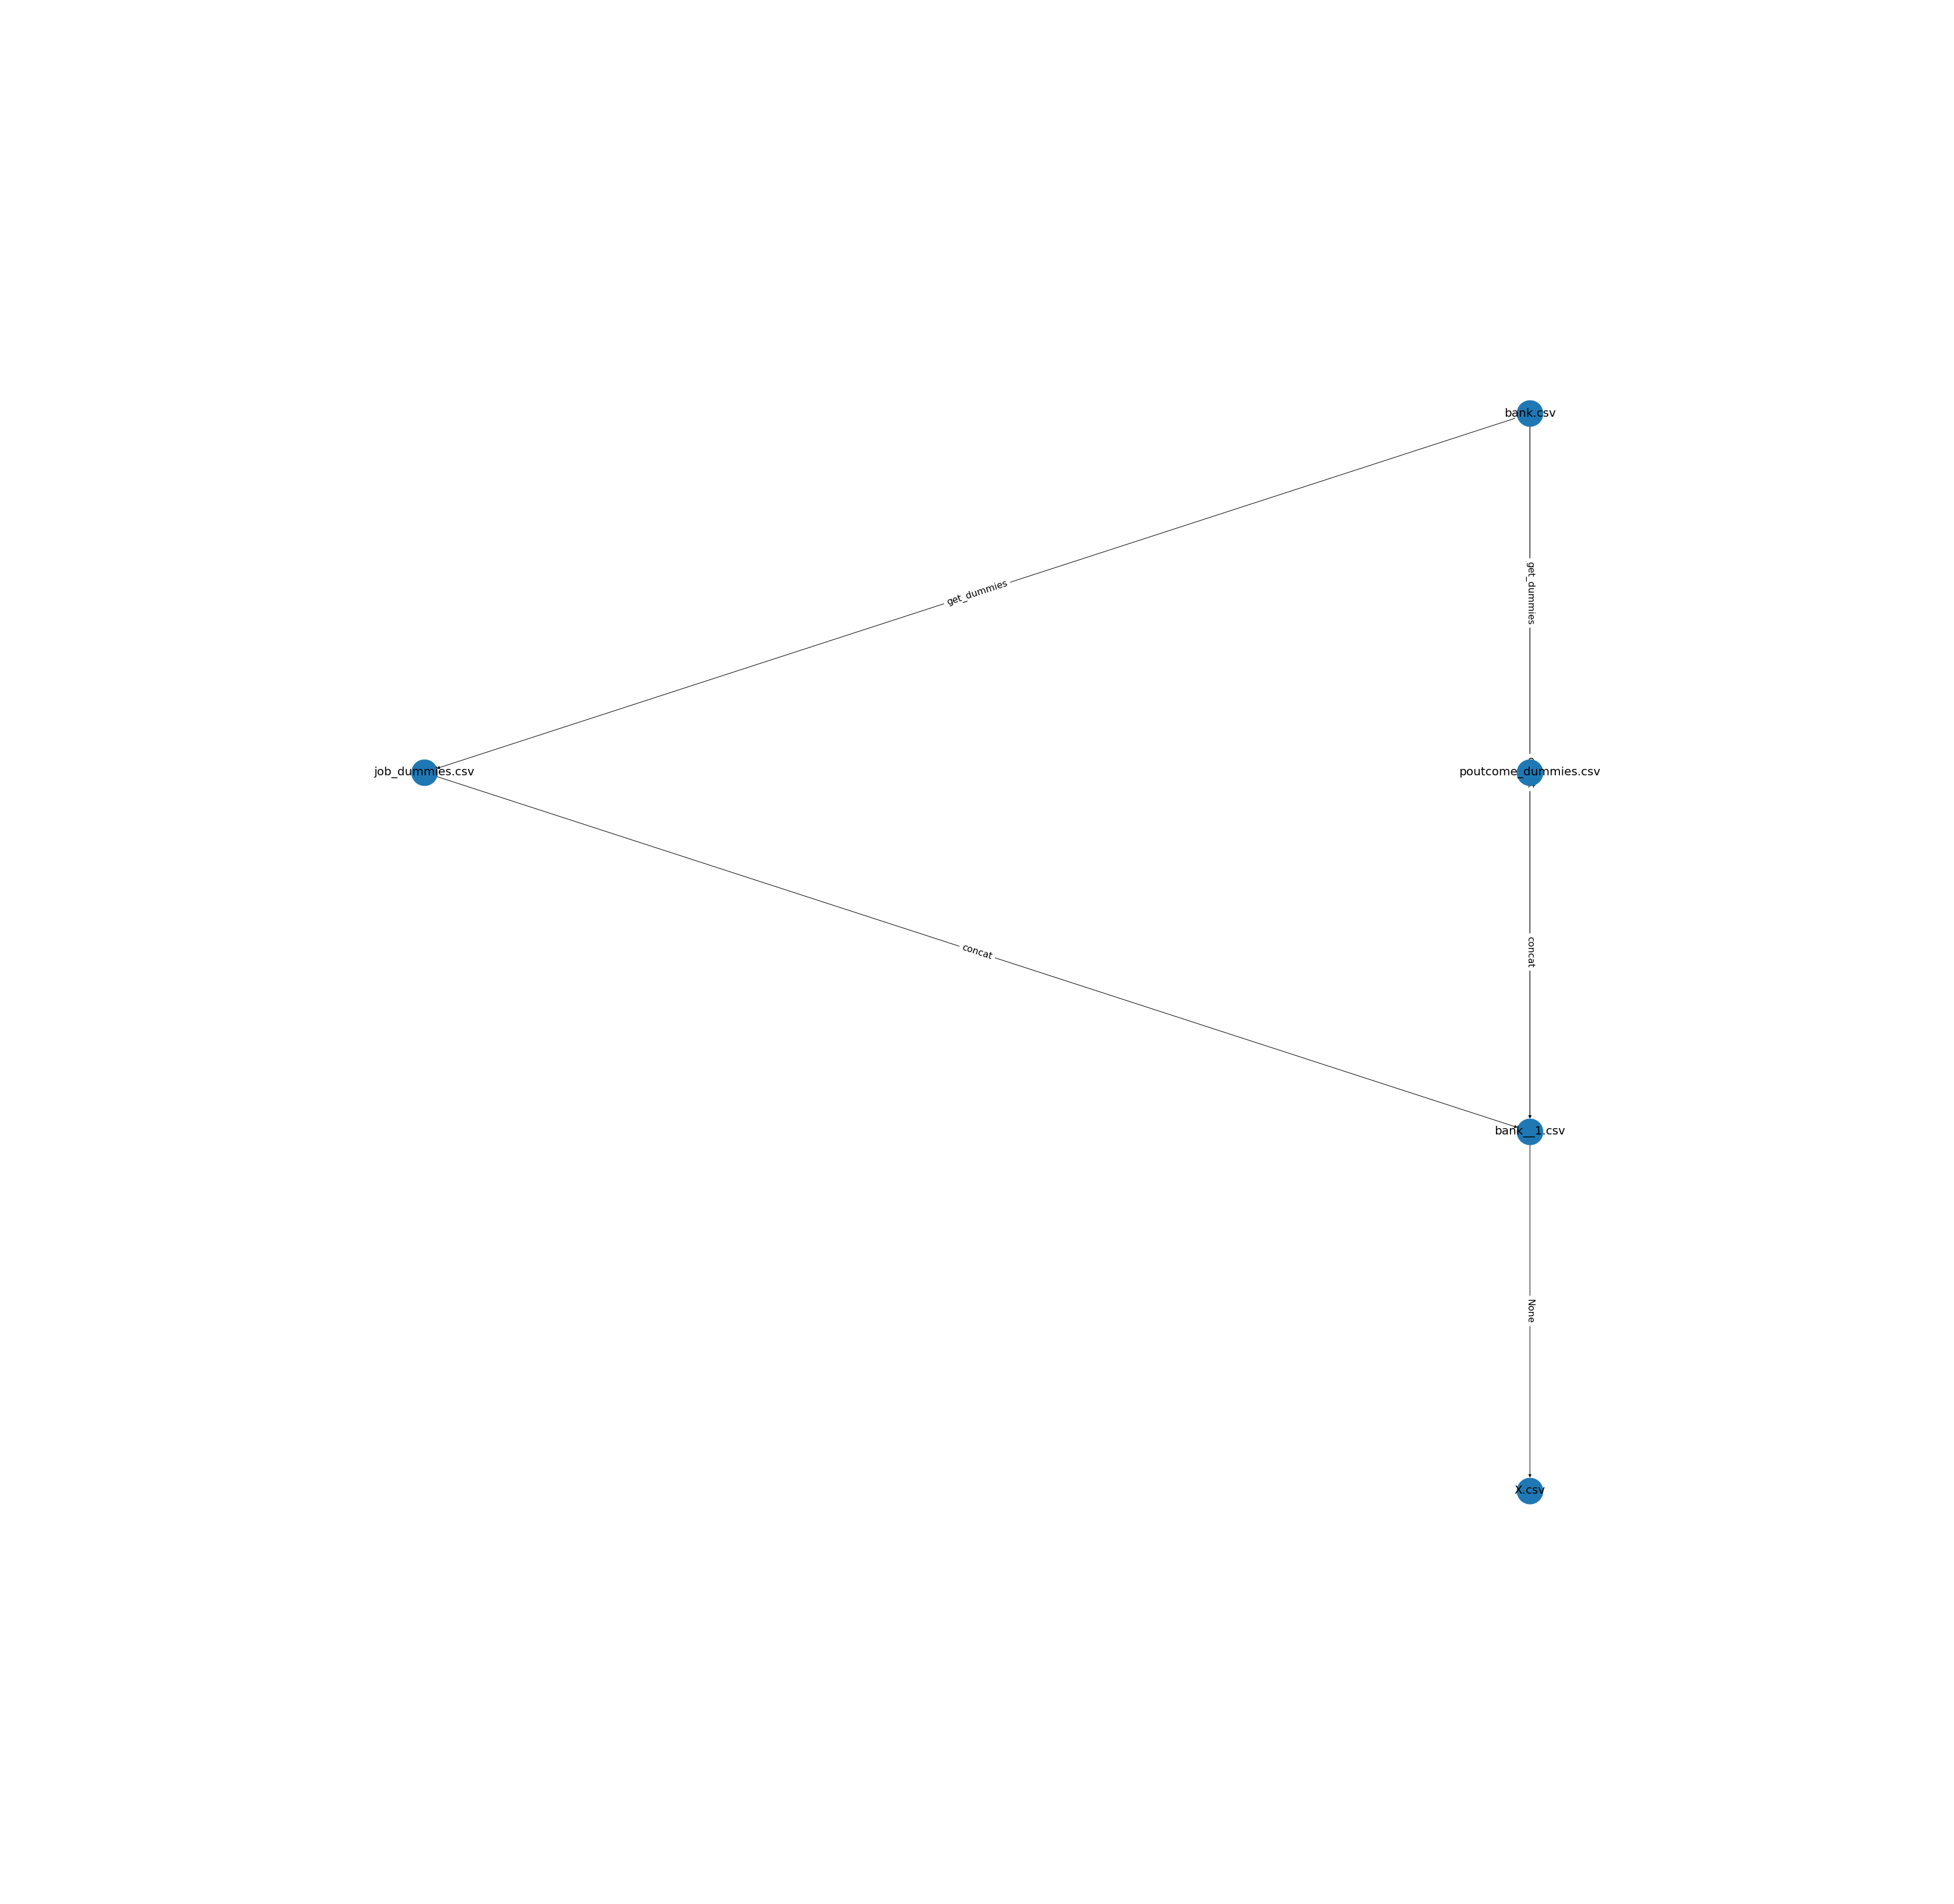

<module 'matplotlib.pyplot' from '/home/suhail/anaconda3/envs/relic/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [97]:
# Inspect a graph here
g = graphs.get_graph(dir3,left_out[0])
graphs.draw_graph(g, canvas_size=(60,60))

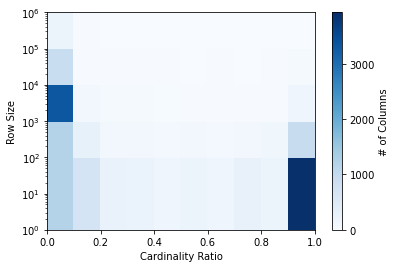

In [620]:
#grouped_freq = df2[['index_len', 'card_ratio', 'colname']].groupby(['index_len','card_ratio']).count().rename({'colname' : 'count'},axis=1).reset_index()
#pivoted = grouped_freq.pivot('index_len','card_ratio','count').fillna(0)
#x_bins = np.arange(0,1.0,0.1)
#y_bins = np.arange(0,df2['index_len'].max,)
#ax = plt.hist2d(data=grouped_freq, x='card_ratio', y='index_len', bins=[])

# https://stackoverflow.com/questions/29175093/creating-a-log-linear-plot-in-matplotlib-using-hist2d

xbins = np.linspace(0, 1, 11)
#ybins = np.logspace(1,np.ceil(np.log10(df2['index_len'].max())+1), 5)#int(np.ceil(np.log10(df2['index_len'].max())+1))*2) # np.linspace(0, 1, 10)
ybins = np.array([1,101,1001, 10001, 100001,1000001])
#ybins[0] = 0.0 # 0 to 100 should be the first bin

counts, xedges, yedges = np.histogram2d(x=df2['card_ratio'], y=df2['index_len'], bins=(xbins, ybins))

fig, ax = plt.subplots()
cm = ax.pcolormesh(xbins, ybins, counts.T, cmap="Blues")

ax.set_yscale('log')
#cbar = fig.colorbar(cm, ticks=np.append(np.arange(counts.min(), counts.max(),1000),counts.max()))
cbar = fig.colorbar(cm, ticks=np.arange(counts.min(), counts.max(),1000))

ax.set_xlabel('Cardinality Ratio')
ax.set_ylabel('Row Size')
cbar.ax.set_ylabel('# of Columns', rotation=90)

plt.show()

In [622]:
yedges -1

array([      0,     100,    1000,   10000,  100000, 1000000])

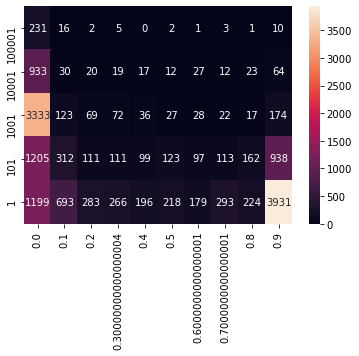

In [627]:
heatmap_df = pd.DataFrame(counts.T.astype(int), index=(ybins)[:-1],columns=xbins[:-1])
sns.heatmap(heatmap_df.iloc[::-1], annot=True, fmt="d")


In [315]:

norm = np.linalg.norm(counts)
normal_counts = counts/norm
normal_counts.T
#fig, ax = plt.subplots()
#cm = ax.pcolormesh(data=counts.T, cmap="Blues")
#plt.imshow(normal_counts.T, cmap='hot', interpolation='nearest')

array([[0.31209673, 0.15036308, 0.05108272, 0.04361548, 0.03852418,
        0.03241461, 0.04921591, 0.05057359, 0.47501835],
       [0.79118812, 0.04039099, 0.01459506, 0.01578303, 0.00797637,
        0.00695811, 0.01086144, 0.00916434, 0.06228358],
       [0.09945007, 0.00560043, 0.00288507, 0.00135768, 0.00152739,
        0.00424275, 0.00203652, 0.00152739, 0.00967347],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ]])

In [268]:
with np.printoptions(precision=3, suppress=True):
    print(ybins)

[1.e+00 1.e+02 1.e+04 1.e+06 1.e+08]


In [333]:
counts.T

array([[2153.,  764.,  338.,  313.,  260.,  338., 2922.],
       [4790.,  173.,  112.,   57.,   59.,   76.,  385.],
       [ 592.,   36.,   14.,   12.,   24.,   21.,   57.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.]])

In [334]:
counts.T[np.digitize(100,ybins)]

array([4790.,  173.,  112.,   57.,   59.,   76.,  385.])

In [401]:
card

array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])

In [313]:
np.digitize(100000,ybins)

3

In [602]:
# Load Faker Cardinality Chart here:
import json

with open('../generator/config_dict.json', 'r') as fp:
    config_dict = json.load(fp)

In [441]:
config_dict

{'row_sizes': [10, 100, 1000, 10000, 100000, 1000000],
 'card_ratios': [0.0,
  0.1,
  0.2,
  0.30000000000000004,
  0.4,
  0.5,
  0.6000000000000001,
  0.7000000000000001,
  0.8,
  0.9],
 'prob_dict': {'10': {'9': {'joinable': ['ascii_company_email',
     'ascii_email',
     'ascii_free_email',
     'ascii_safe_email',
     'bban',
     'bothify',
     'building_number',
     'company_email',
     'credit_card_number',
     'ean',
     'ean13',
     'ean8',
     'ein',
     'email',
     'free_email',
     'hostname',
     'iban',
     'invalid_ssn',
     'ipv4',
     'ipv4_private',
     'ipv4_public',
     'ipv6',
     'isbn10',
     'isbn13',
     'iso8601',
     'itin',
     'license_plate',
     'mac_address',
     'md5',
     'msisdn',
     'password',
     'pystr',
     'safe_email',
     'sha1',
     'sha256',
     'ssn',
     'unix_time',
     'user_name',
     'uuid4',
     'word',
     'zipcode',
     'zipcode_in_state',
     'zipcode_plus4'],
    'groupable': ['city',
     

In [591]:
def search_lower(config_dict, card_choice, col_type=None):
    c = card_choice
    while c >= 0:
        if str(c) not in config_dict['prob_dict'][str(row_floor)]:
            pass
        elif col_type is not None:
            if col_type in config_dict['prob_dict'][str(row_floor)][str(c)]:
                return config_dict['prob_dict'][str(row_floor)][str(c)][col_type]
        else:
            return [item for sublist in config_dict['prob_dict'][str(row_floor)][str(card_choice)].values() for item in sublist]
        c -= 1
    
    #Did not find the requested type at all
    return None

def search_upper(config_dict, card_choice, col_type=None, num_bins=10):
    c = card_choice
    print(col_type, 'entry', c)
    while c < num_bins:
        if str(c) not in config_dict['prob_dict'][str(row_floor)]:
            pass
        elif col_type is not None:
            if col_type in config_dict['prob_dict'][str(row_floor)][str(c)]:
                print(col_type ,'exit', c)
                return config_dict['prob_dict'][str(row_floor)][str(c)][col_type]
        else:
            print(col_type, 'exit', c)
            return [item for sublist in config_dict['prob_dict'][str(row_floor)][str(card_choice)].values() for item in sublist]
        c += 1
    
    #Did not find the requested type at all
    print(col_type, 'final exit', c)
    return None


def select_column_from_dist(config_dict, counts, num_rows, col_type=None):
    # First try to get column of requested type
    ybins = [11,101,1001,10001,100001,1000001]
    
    row_index = min(min(np.digitize(num_rows, ybins)-1, len(ybins)-1), config_dict['row_sizes'][-1])
    row_floor = config_dict['row_sizes'][row_index]
    
    card_prob = counts.T[row_index] / counts.T[row_index].sum()
    card_choice = np.random.choice(range(len(card_prob)), 1, p=card_prob)[0]
    
    col_options = search_lower(config_dict, card_choice, col_type=col_type)
    if not col_options:
        col_options = search_upper(config_dict, card_choice, col_type=col_type, num_bins=len(card_prob))
    
    if not col_options:
        #Error
        print("COULD NOT FIND OPTION IN SELECTED ROW BRACKET")
    
    return np.random.choice(col_options, 1)[0]

In [560]:
select_column_from_dist(config_dict, counts, 1000)

'file_name'

In [506]:
pd.Series([select_column_from_dist(config_dict, counts, 10) for _ in range(1000)]).hist()

UnboundLocalError: local variable 'selection' referenced before assignment

In [532]:
counts.T

array([[1293.,  694.,  208.,  401.,  180.,  112.,  402.,  223., 3969.],
       [1236.,  296.,  141.,  107.,  121.,  113.,  139.,  167.,  951.],
       [3353.,  131.,   55.,   76.,   29.,   36.,   26.,   21.,  174.],
       [ 938.,   31.,   21.,   18.,   19.,   26.,   16.,   20.,   68.],
       [ 232.,   16.,    3.,    3.,    1.,    2.,    3.,    0.,   11.]])

In [541]:
ybins


array([      1,     101,    1001,   10001,  100001, 1000001])

In [599]:
## Testing

for num_rows in [10,100,1000, 10000, 100000]:
    row_index = min(min(np.digitize(num_rows, ybins)-1, len(ybins)-1), config_dict['row_sizes'][-1])
    row_floor = config_dict['row_sizes'][row_index]

    card_prob = counts.T[row_index] / counts.T[row_index].sum()
    card_choice = np.random.choice(range(len(card_prob)), 1, p=card_prob)[0]
    col_options = None
    print('rows', num_rows)
    for col_type in ['numeric', 'string', 'groupable', 'joinable']:
        for card_choice in range(10):
            col_options = search_lower(config_dict, card_choice, col_type=col_type)
            if not col_options:
                col_options = search_upper(config_dict, card_choice, col_type=col_type, num_bins=len(card_prob))
            if not col_options:
                print('E:', num_rows, row_floor, card_choice, col_type)
                

rows 10
numeric entry 0
numeric exit 5
numeric entry 1
numeric exit 5
numeric entry 2
numeric exit 5
numeric entry 3
numeric exit 5
numeric entry 4
numeric exit 5
string entry 0
string exit 8
string entry 1
string exit 8
string entry 2
string exit 8
string entry 3
string exit 8
string entry 4
string exit 8
string entry 5
string exit 8
string entry 6
string exit 8
string entry 7
string exit 8
groupable entry 0
groupable exit 2
groupable entry 1
groupable exit 2
joinable entry 0
joinable exit 9
joinable entry 1
joinable exit 9
joinable entry 2
joinable exit 9
joinable entry 3
joinable exit 9
joinable entry 4
joinable exit 9
joinable entry 5
joinable exit 9
joinable entry 6
joinable exit 9
joinable entry 7
joinable exit 9
joinable entry 8
joinable exit 9
rows 100
numeric entry 0
numeric exit 5
numeric entry 1
numeric exit 5
numeric entry 2
numeric exit 5
numeric entry 3
numeric exit 5
numeric entry 4
numeric exit 5
string entry 0
string exit 8
string entry 1
string exit 8
string entry 2
s

In [593]:
config_dict['prob_dict']['10']['9']

['ascii_company_email',
 'ascii_email',
 'ascii_free_email',
 'ascii_safe_email',
 'bban',
 'bothify',
 'building_number',
 'company_email',
 'credit_card_number',
 'ean',
 'ean13',
 'ean8',
 'ein',
 'email',
 'free_email',
 'hostname',
 'iban',
 'invalid_ssn',
 'ipv4',
 'ipv4_private',
 'ipv4_public',
 'ipv6',
 'isbn10',
 'isbn13',
 'iso8601',
 'itin',
 'license_plate',
 'mac_address',
 'md5',
 'msisdn',
 'password',
 'pystr',
 'safe_email',
 'sha1',
 'sha256',
 'ssn',
 'unix_time',
 'user_name',
 'uuid4',
 'word',
 'zipcode',
 'zipcode_in_state',
 'zipcode_plus4']

In [595]:
len(card_prob)

9

In [597]:
xbins

array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])

In [600]:
counts

array([[1199., 1205., 3333.,  933.,  231.],
       [ 693.,  312.,  123.,   30.,   16.],
       [ 283.,  111.,   69.,   20.,    2.],
       [ 266.,  111.,   72.,   19.,    5.],
       [ 196.,   99.,   36.,   17.,    0.],
       [ 218.,  123.,   27.,   12.,    2.],
       [ 179.,   97.,   28.,   27.,    1.],
       [ 293.,  113.,   22.,   12.,    3.],
       [ 224.,  162.,   17.,   23.,    1.],
       [3931.,  938.,  174.,   64.,   10.]])

In [601]:
config_dict

{'row_sizes': [10, 100, 1000, 10000, 100000, 1000000],
 'card_ratios': [0.0,
  0.1,
  0.2,
  0.30000000000000004,
  0.4,
  0.5,
  0.6000000000000001,
  0.7000000000000001,
  0.8,
  0.9],
 'prob_dict': {'10': {'9': {'joinable': ['ascii_company_email',
     'ascii_email',
     'ascii_free_email',
     'ascii_safe_email',
     'bban',
     'bothify',
     'building_number',
     'company_email',
     'credit_card_number',
     'ean',
     'ean13',
     'ean8',
     'ein',
     'email',
     'free_email',
     'hostname',
     'iban',
     'invalid_ssn',
     'ipv4',
     'ipv4_private',
     'ipv4_public',
     'ipv6',
     'isbn10',
     'isbn13',
     'iso8601',
     'itin',
     'license_plate',
     'mac_address',
     'md5',
     'msisdn',
     'password',
     'pystr',
     'safe_email',
     'sha1',
     'sha256',
     'ssn',
     'unix_time',
     'user_name',
     'uuid4',
     'word',
     'zipcode',
     'zipcode_in_state',
     'zipcode_plus4'],
    'groupable': ['city',
     

In [604]:
import pickle
pickle.dump(counts, open( "../generator/counts.pkl", "wb" ))

In [605]:
counts = pickle.load(open( "../generator/counts.pkl", "rb" ))

In [606]:
counts

array([[1199., 1205., 3333.,  933.,  231.],
       [ 693.,  312.,  123.,   30.,   16.],
       [ 283.,  111.,   69.,   20.,    2.],
       [ 266.,  111.,   72.,   19.,    5.],
       [ 196.,   99.,   36.,   17.,    0.],
       [ 218.,  123.,   27.,   12.,    2.],
       [ 179.,   97.,   28.,   27.,    1.],
       [ 293.,  113.,   22.,   12.,    3.],
       [ 224.,  162.,   17.,   23.,    1.],
       [3931.,  938.,  174.,   64.,   10.]])